<a href="https://colab.research.google.com/github/wintercameearly/undergrad_proj/blob/master/Copy_of_EnergyDisaggregationDemo_View.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at . 

      http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,  
software distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Pre-work

In [0]:
# @title Upload files (skip this if this is run locally)

# Use this cell to update the following files
#   1. requirements.txt
#   2. e2e_demo_credential.json
from google.colab import files
uploaded = files.upload()

Saving e2e_demo_credential.json to e2e_demo_credential.json


In [0]:
# @title Install missing packages

# run this cell to install packages if some are missing
!pip install -r ./requirements.txt

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 696kB 6.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 102kB 7.7MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 13.8MB 258kB/s 
     |████████████████████████████████| 24.3MB 1.5MB/s 
     |████████████████████████████████| 12.6MB 43.4MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 
     |████████████████████████████████| 2.1MB 39.8MB/s 
     |████████████████████████████████| 92kB 9.0MB/s 
     |████████████████████████████████| 112kB 42.5MB/s 
  Created wheel for gcsfs: filename=gcsfs-0.2.0-cp27-none-any.whl size=26893 sha256=e219cc7dc63eb327242d24a360c844b5767c7bd048b4545d155057f51e94266c
  Stored in directory: /root/.cache/pip/wheels/0a/3c/83/fe2a541de7b1a999b2e6fc7443

In [0]:
# @title Import libraries

%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import pandas as pd
import pandas_gbq
import seaborn as sns
import time
import Queue as queue
from google.cloud import pubsub_v1
from IPython import display

In [0]:
# @title Configurations

# project related
GOOGLE_CLOUD_PROJECT = 'my-project-fy' #@param
GOOGLE_APPLICATION_CREDENTIALS = 'e2e_demo_credential.json' #@param
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS

# data related
DATASET_ID = 'EnergyDisaggregation'

# pubsub related
PRED_TOPIC = 'pred'
SUB_NAME = 'sub1'
DEVICE_ID = 'fy-raspi' #@param

# BQ data loading

In [0]:
# @title Utility

def get_appliance_info(project_id, dataset):
    """Get appliance info from the big query table.
    
    Load appliance info from big query table.
    
    Args:
      project_id: str, google cloud project id.
      dataset: str, name of the dataset.
    Returns:
      pandas.DataFrame, appliance info.
    """
    res = pandas_gbq.read_gbq(
        'SELECT * FROM {}.ApplianceInfo'.format(dataset),
        project_id,
        dialect='legacy')
    return res

def load_ground_truth(project_id, dataset, appliance_id):
    """Load ground-truth data of a specified appliance from big query table.

    Load true appliance status from big query data.

    Args:
        project_id: str, google project id.
        dataset: str, dataset name.
        appliance_id: int, appliance id.
    Returns:
        pandas.DataFrame, ground truth appliance status.
    """
    query = """
    SELECT * FROM {}.ApplianceStatusGroundTruth
    WHERE appliance_id = {}
    ORDER BY time
    """.format(dataset, appliance_id)
    return pandas_gbq.read_gbq(query,
                               project_id,
                               index_col='time',
                               dialect='legacy')

def load_data(project_id, dataset, app_ids):
    """Load ground-truth data from big query table.

    Load true appliance status from big query data.

    Args:
        project_id: str, google project id.
        dataset: str, dataset name.
        app_ids: list, appliances' ids.
    Returns:
        dict, {appliance_id: ground truth data (pandas.DataFrame)}
    """
    print('Loading ground truth data ...')
    gt = {}
    for k in app_ids:
        gt[k] = load_ground_truth(project_id, dataset, k)
    print('Data loaded.')
    return gt

In [0]:
# @title Load appliance info

app_info = get_appliance_info(GOOGLE_CLOUD_PROJECT, DATASET_ID)
app_info

,appliance_name,appliance_id
0,running_machine,0
1,washing_machine,1
2,dish_washer,2
3,microwave,3
4,toaster,4
5,kettle,5
6,rice_cooker,6
7,cooker,7


In [0]:
# @title Create appliance Id to name mapping

app_id_name_map = {row[1]: row[0] for i, row in app_info.iterrows()}
app_id_name_map

{0: u'running_machine',
 1: u'washing_machine',
 2: u'dish_washer',
 3: u'microwave',
 4: u'toaster',
 5: u'kettle',
 6: u'rice_cooker',
 7: u'cooker'}

In [0]:
# @title Load ground truth data (this can take some time)
ground_truth = load_data(project_id=GOOGLE_CLOUD_PROJECT,
                         dataset=DATASET_ID,
                         app_ids=app_id_name_map.keys())

Loading ground truth data ...
Data loaded.


# Start subscriber

When the following cell is run, it will pull messages from a pub/sub topic.  
The message contains both raw power readings and prediction results from CMLE.  
It plots the raw active powers, it also updates precision/recall for each appliance.  

In [0]:
# @title Utility

class MsgProcesser(object):
    """Subscribe to a pub/sub topic and process incoming messages."""
    
    def __init__(self,
                 project_id,
                 ground_truth,
                 topic_name,
                 subscription_name,
                 app_id_name_map,
                 target_device):
        # member initialization
        self._gt = ground_truth
        self._data = pd.Series(np.zeros(self._gt[0].shape[0]),
                                index=self._gt[0].index)
        self._app_id_to_name = app_id_name_map
        self._target_device = target_device
        self._app_names = [app_id_name_map[k]
                           for k in range(len(app_id_name_map.keys()))]
        self._queue = queue.Queue(maxsize=100000)
        # create subsciprtion
        self._subscriber, self._subscription_path = (
            self.create_subscription(project_id, topic_name, subscription_name))
        self._subscriber.subscribe(self._subscription_path,
                                   callback=self._msg_callback)
        
    def create_subscription(self, project_id, topic_name, subscription_name):
        """Create a subscription in pub/sub.
    
        Before listening to incoming messages, we need to define a subscription.
        This function creates a new subscription only if it does not exist.

        Args:
          project_id: str, google cloud project id.
          topic_name: str, topic name.
          subscription_name: str, name of the new subscription.
        Returns:
          (google.cloud.pubsub_v1.SubscriberClient, topic_path)
        """
        print('Creating subscription "{}" to topic "{}" ...'.format(
            subscription_name, topic_name))
        try:
            subscriber = pubsub_v1.SubscriberClient()
            topic_path = subscriber.topic_path(project_id, topic_name)
            subscription_path = subscriber.subscription_path(
                project_id, subscription_name)
            # if the subscription exists, exception is raised here
            subscription = subscriber.create_subscription(
                subscription_path, topic_path)
            print('Subscription created: {}'.format(subscription))
        except Exception as e:
            print('Subscription "{}" existed.'.format(subscription_name))
        return subscriber, subscription_path
    
    def async_pull_msg(self):
        """Pull messages asynchronously from pub/sub topic."""
        # initialize metrics
        self._metrics = [{'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
                         for k in range(len(self._app_id_to_name))]
        precisions = [0. for k in self._app_id_to_name]
        recalls = [0. for k in self._app_id_to_name]
        # initialize UI
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))
        sns.axes_style('white')
        # receive data and update UI
        print('Listening for messages on {} ...'.format(
          self._subscription_path))
        max_t = None
        while(True):
            # collect data from callback threads
            t, d, probs = self._queue.get()
            if max_t is None:
                max_t = t
            else:
                max_t = max(t, max_t)
            self._data.at[t] = d
            for k in self._app_id_to_name:
                truth = self._gt[k].status.at[t]
                pred = 1 if probs[k] >= 0.5 else 0
                if truth == 1 and pred == 1:
                    self._metrics[k]['TP'] += 1
                elif truth == 0 and pred == 0:
                    self._metrics[k]['TN'] += 1
                elif truth == 1 and pred == 0:
                    self._metrics[k]['FN'] += 1
                else:
                    self._metrics[k]['FP'] += 1
                TP = self._metrics[k]['TP']
                FP = self._metrics[k]['FP']
                FN = self._metrics[k]['FN']
                precisions[k] = (
                  np.nan if TP + FP == 0 else round(1.0 * TP / (TP + FP), 2))
                recalls[k] = (
                  np.nan if TP + FN == 0 else round(1.0 * TP / (TP + FN), 2))
                
            score_matrix = pd.DataFrame({'Precision': precisions,
                                         'Recall': recalls},
                                        index=self._app_names)
                        
            # update view in the main thread
            ax.clear()
            x = max_t.astype('datetime64[h]')
            mask = (self._data.index >= x) & (self._data.index < x + 1)
            ax = sns.lineplot(data=self._data[mask], linewidth=2.5, ax=ax)
            ax.set_xlabel('time')
            ax.set_ylabel('active power')
            ax.set_ylim(bottom=0)
            title = 'Device: {}, Date: {} (UTC)'.format(
              self._target_device, max_t.astype('datetime64[D]'))
            ax.set_title(title)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            display.display(score_matrix)
            
    def _msg_callback(self, message):
        """Pub/sub pull callback."""
        try:
            data = json.loads(message.data.decode('utf-8'))
            device_id = data['device_id']
            if device_id == self._target_device:
              t = np.datetime64(data['time'][-1])
              d = data['data'][-1]
              probs = data['probs']
              self._queue.put((t, d, probs))
        except Exception as e:
            print('Error: {}'.format(e))
        message.ack()

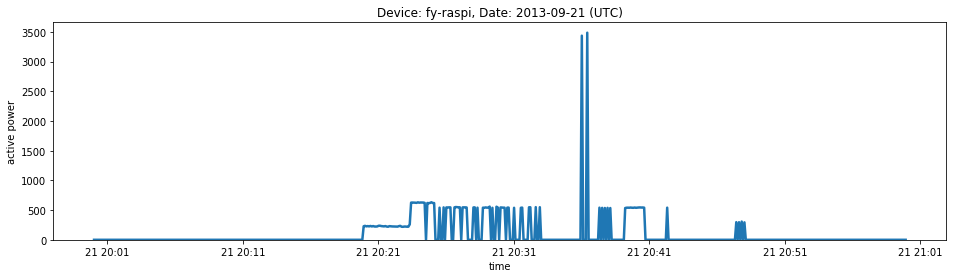

,Precision,Recall
running_machine,NaN,NaN
washing_machine,0.00,NaN
dish_washer,NaN,NaN
microwave,NaN,NaN
toaster,NaN,NaN
kettle,0.67,1.00
rice_cooker,1.00,0.91
cooker,NaN,0.00


In [0]:
# @title Visualization

tt = MsgProcesser(project_id=GOOGLE_CLOUD_PROJECT,
                  ground_truth=ground_truth,
                  topic_name=PRED_TOPIC,
                  subscription_name=SUB_NAME,
                  app_id_name_map=app_id_name_map,
                  target_device=DEVICE_ID)
tt.async_pull_msg()